## 混合ガウスモデル
混合ガウスモデルの実装を行う。

### 1. 準備

#### 1.1.必要なライブラリのインストール

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, wishart, dirichlet
import scipy.stats as stats
plt.style.use('ggplot') 
%matplotlib inline

##### 1.2.観測データの用意
クラス数を3として、3つのガウス分布に従うデータを用意する。このデータをもとに真の分布の推定を行う。まず3つのガウス分布の平均と分散を与える。

In [77]:
Dim_Observable = 2
K_Observable = 3
N = 250
mean = np.array( [ [0.0, 4.0], [-5.0, -5.0], [5.0,-2.5] ])
cov = np.array( [ [ [8.0, 0.0], [0.0, 8.0] ],  [ [4.0, -2.5], [-2.5, 4.0] ], [ [6.5, 4.0], [4.0, 6.5] ] ] )

データが下記の割合でそれぞれのクラスに分類されているデータを想定する。

In [78]:
pi_Observable = np.array([0.5, 0.2, 0.3])

In [79]:
data_k = np.random.multinomial(n=1, pvals=pi_Observable, size=N)
print(data_k[0:5])

[[0 1 0]
 [0 0 1]
 [1 0 0]
 [0 1 0]
 [1 0 0]]


In [80]:
_, data_y = np.where(data_k == 1)
data_x = np.array( [ np.random.multivariate_normal ( mean = mean[k], cov=cov[k], size=1).flatten() for k in data_y ] )

In [81]:
print(data_x[0:5])

[[-5.10308538 -5.57163808]
 [ 6.46512447 -0.67638129]
 [ 0.20570283  9.33883904]
 [-3.75737689 -4.73303961]
 [-1.18907137  1.88891898]]


生成されたデータをプロットしてみる。このデータをもとに、真の分布の推定を行う。

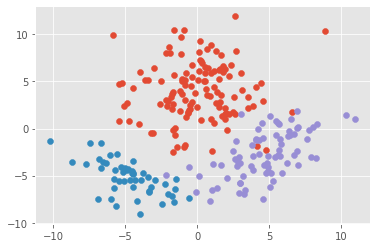

In [82]:
for k in range(K_Observable):
    k_id = np.where(data_y == k)
    plt.scatter( data_x[k_id,0], data_x[k_id,1] )

## 2. ガウス混合モデルによる推論

### 2.1. ガウス混合モデル
パラメータが、$\vec\theta_k = \{ \vec{\mu}_k, \Lambda_k \} $で与えられてる時、$n$番目のデータ$\vec{x}_n$の条件付き確率分布は、
$$
p( \vec{x}_n | \vec{s}_n, \vec{\mu}_k, \Lambda_k ) = \prod^K_{k=1} \mathcal{N}(\vec{x}_n| \vec{\mu}_k, \Lambda_k)^{s_{n,k}}
$$
で与えられる。ベイズ推定アプローチを用いる為に使用する、パラメータの事前分布は、尤度関数の事前共役分布であるガウス・ウィシャート分布：
$$
p(\vec{\mu}_k,\Lambda_k) = \mathcal{N}(\vec{\mu}_k|\vec{m}, (\beta\Lambda_k)^{-1})\mathcal{W}(\Lambda_k|\nu,\vec{W})
$$
を用いる。

#### パラメーターの初期化

In [83]:
def initialize_parameter( DimofData, NumOfClass ):
    mean = np.random.rand( NumOfClass, DimofData  )
    Lambd = np.array( [ np.identity( DimofData )*0.01 for k in range(NumOfClass) ] )
    pi = np.random.rand( NumOfClass )
    pi /= np.sum( pi )
    pi = pi.reshape( pi.shape[0], 1 )
    
    parameters = {"mean": mean,
                           "Lambd": Lambd,
                           "pi": pi }
    return parameters

In [84]:
parameters = initialize_parameter(2 ,3)
parameters

{'mean': array([[0.57066924, 0.60157175],
        [0.85509021, 0.58409985],
        [0.49560053, 0.61685679]]), 'Lambd': array([[[0.01, 0.  ],
         [0.  , 0.01]],
 
        [[0.01, 0.  ],
         [0.  , 0.01]],
 
        [[0.01, 0.  ],
         [0.  , 0.01]]]), 'pi': array([[0.42342589],
        [0.51415078],
        [0.06242333]])}

#### 潜在変数のサンプルリング
MCMCの一種であるギブスサンプリングによって潜在変数をサンプリングする。

In [85]:
def sampling_of_s( data_x,  parameters ):
    
    NumOfClass = parameters["mean"].shape[0]
    NumOfData = data_x.shape[0]
    mean = parameters["mean"]
    Lambd = parameters["Lambd"]
    pi = parameters["pi"]
    
    eta = np.zeros( ( NumOfData , NumOfClass ) ) 
    
    for k in range( NumOfClass ):
        ref_k = 0.0
        ref_k = - 0.5 * np.diag( ( data_x - mean[k,:] ).dot( Lambd[k,:,:]).dot( ( data_x - mean[k,:] ).T ) ).copy()
        ref_k += 0.5 * np.log( np.linalg.det( Lambd[k,:,:] ) + 1e-7 ) + np.log( pi[k] ) 
        eta[:, k] =  np.exp( ref_k )
    eta /= np.sum(eta, axis=1, keepdims=True)
    
    s = np.zeros( ( NumOfData , NumOfClass ) )
    for n in range( NumOfData ):
        s[n] = np.random.multinomial(n=1, pvals=eta[n,:], size=1).flatten()

    return s

In [86]:
sampling_of_s( data_x, parameters )[0:5]

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.]])

#### 事後分布のパラメータ$\mu$および$\Lambda$の生成

In [87]:
def create_parameter(data_x, s, beta=1.0, v=3.0, alpha = 1 ):
    
    NumOfClass = s.shape[1]
    Dim = data_x.shape[1]
    w = np.identity(Dim)*10
    beta_hat = np.zeros(NumOfClass)
    m = np.zeros( ( 1, Dim ) )
    m_hat = np.zeros( ( NumOfClass, Dim ) )
    W_hat = np.zeros( ( NumOfClass, Dim, Dim ) )
    v_hat = np.zeros(NumOfClass)
    alpha_hat = np.zeros( NumOfClass )
    
    beta_hat = np.sum(s, axis=0 ) + beta
    m_hat = ( np.dot( s.T , data_x ) + beta * m ) / beta_hat.reshape( NumOfClass, 1 )
    for k in range(NumOfClass):
        W_hat_inv = np.dot( ( s[ : , k ] * data_x.T ) , data_x )
        W_hat_inv += beta * m * m.T
        W_hat_inv -= beta_hat[k] * m_hat[k,:].reshape(Dim,1) * m_hat[k,:].reshape(1,Dim)
        W_hat_inv += np.linalg.inv(w) 
        W_hat[ k , : , : ] = np.linalg.inv(W_hat_inv)
    v_hat = np.sum(s, axis=0 ) + v
    alpha_hat = np.sum(s, axis=0 ) + alpha
    
    c_parameters = {"beta_hat":beta_hat,
                           "m_hat": m_hat,
                           "W_hat": W_hat,
                           "v_hat": v_hat,
                           "alpha_hat": alpha_hat }
    
    return c_parameters

In [88]:
s = sampling_of_s( data_x, parameters )
create_parameter(data_x, s)

{'beta_hat': array([118., 117.,  18.]),
 'm_hat': array([[ 0.36125824,  0.05200808],
        [ 0.54195384,  0.29152114],
        [ 1.04346484, -0.45977847]]),
 'W_hat': array([[[ 6.58486968e-04, -5.98681229e-05],
         [-5.98681229e-05,  3.60032169e-04]],
 
        [[ 4.44904430e-04, -5.27137993e-05],
         [-5.27137993e-05,  4.10786171e-04]],
 
        [[ 5.31225243e-03,  1.90010897e-03],
         [ 1.90010897e-03,  3.32231979e-03]]]),
 'v_hat': array([120., 119.,  20.]),
 'alpha_hat': array([118., 117.,  18.])}

### 事後分布からパラメーターを生成

#### Lambdaのサンプル

In [89]:
def sampling_parameters(c_parameters):
    
    beta_hat = c_parameters["beta_hat"]
    m_hat = c_parameters["m_hat"]
    v_hat = c_parameters["v_hat"]
    W_hat = c_parameters["W_hat"]
    alpha_hat = c_parameters["alpha_hat"]
    
    NumOfClass = W_hat.shape[0]
    sampling_lambd = np.zeros( W_hat.shape )
    sampling_mu = np.zeros( m_hat.shape )
    sampling_pi = np.zeros( NumOfClass )
    
    for k in range( NumOfClass ):
        sampling_lambd[k, :, : ] = wishart.rvs(size = 1, df=v_hat[k], scale=W_hat[k, :, :])
        sampling_mu[k,:] = np.random.multivariate_normal( mean=m_hat[k,:], cov=np.linalg.inv(beta_hat[k] * sampling_lambd[k, :, :] ), size=1 )
        
    sampling_pi = dirichlet.rvs( size=1, alpha=alpha_hat ).T

    sample_params = { "mean": sampling_mu,
                                "Lambd" : sampling_lambd,
                            "pi": sampling_pi }
    
    return sample_params

In [90]:
c_parameters = create_parameter(data_x, s)
sampling_parameters(c_parameters)

{'mean': array([[-0.26360508,  0.42878855],
        [ 0.7993428 ,  0.02078098],
        [ 0.82572316, -0.99440187]]),
 'Lambd': array([[[ 0.07518106, -0.00162463],
         [-0.00162463,  0.0412649 ]],
 
        [[ 0.04821581, -0.00563071],
         [-0.00563071,  0.05126197]],
 
        [[ 0.11491103,  0.02115629],
         [ 0.02115629,  0.04805027]]]),
 'pi': array([[0.49412725],
        [0.44682483],
        [0.05904792]])}

### モデル

In [91]:
def model_gaussian_mixture( data_x, DimofData, NumOfClass, iterater = 400 , draw = True):
    parameters = initialize_parameter( DimofData, NumOfClass )
    s_mean = 0.0
    for i in range(iterater):
        s = sampling_of_s( data_x,  parameters )
        c_parameters = create_parameter( data_x, s )
        parameters = sampling_parameters( c_parameters )
        
        if draw == True:
            if i % 50 == 0:
                print("iterater is ( ", i , "/ ", iterater, ")",  int ( i / 50 ) * "⬛︎" )
    print( " -----------------------------------------------------------")
    print( "　　　　　　THIS MODEL WAS CODED BY NONAKA SOSHI　　　　　　　　" )
    print( "                       NONAPY 2021                         " )
    print( " -----------------------------------------------------------")
    return parameters

## 3.実行
作ったモデルを実際に使用してみる。

In [96]:
parameters = model_gaussian_mixture( data_x, 2, 3 ,draw=True)

iterater is (  0 /  400 ) 
iterater is (  50 /  400 ) ⬛︎
iterater is (  100 /  400 ) ⬛︎⬛︎
iterater is (  150 /  400 ) ⬛︎⬛︎⬛︎
iterater is (  200 /  400 ) ⬛︎⬛︎⬛︎⬛︎
iterater is (  250 /  400 ) ⬛︎⬛︎⬛︎⬛︎⬛︎
iterater is (  300 /  400 ) ⬛︎⬛︎⬛︎⬛︎⬛︎⬛︎
iterater is (  350 /  400 ) ⬛︎⬛︎⬛︎⬛︎⬛︎⬛︎⬛︎
 -----------------------------------------------------------
　　　　　　THIS MODEL WAS CODED BY NONAKA SOSHI　　　　　　　　
                       NONAPY 2021                         
 -----------------------------------------------------------


これで推定は完了。実際得られたパラメータ（のサンプル）は以下。

In [97]:
print(parameters)

{'mean': array([[-3.64980567, -4.93206902],
       [ 0.20264346,  3.91127587],
       [ 4.88134156, -2.66565472]]), 'Lambd': array([[[ 0.14754737,  0.08182102],
        [ 0.08182102,  0.42141188]],

       [[ 0.17266559,  0.00530542],
        [ 0.00530542,  0.08624284]],

       [[ 0.20673888, -0.13237038],
        [-0.13237038,  0.21821057]]]), 'pi': array([[0.21297931],
       [0.48039215],
       [0.30662854]])}


このパラメータを用いてガウス分布を描くとこんな感じ。

In [98]:
x = np.arange(-10, 10, 0.5)
y = np.arange(-10, 10, 0.5)
X, Y = np.meshgrid(x, y)

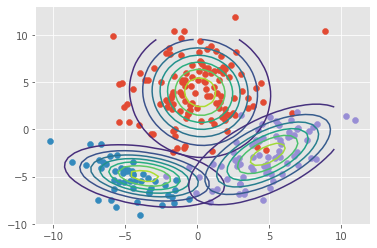

In [99]:
for k in range(3):
    mu = parameters["mean"][k]
    sigma = np.linalg.inv( parameters["Lambd"][k] )
    f = lambda x, y: stats.multivariate_normal(mu, sigma).pdf([x, y])
    Z = np.vectorize(f)(X, Y)
    plt.contour(X, Y, Z)
    k_id = np.where(data_y == k)
    plt.scatter( data_x[k_id,0], data_x[k_id,1] )
plt.show()